<a href="https://colab.research.google.com/github/JiaminJIAN/20MA573/blob/master/src/Euler_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Euler method**

## **Exercise:**

Consider CEV(constant elasticity of variance model)

$$d S_{t} = 0.03 S_{t} \, d t + \sigma S_{t}^{\gamma} \, d W_{t}, \, S_{0} = 100.$$

- Write a pseudo code and python code for vanilla option price.

- For $\sigma = 0.2$ and $\gamma = 1$, compute call price with $T = 1$ and $K = 97$. Dose it recover option price given by BSM formula?

- Can you demostrate the weak or strong convergence rate?

- Download option data and calibrate volatility and elasticity constant from 5 month call options.

## **Solution:**

(1) Write a pseudo code and python code for vanilla option price.

The pseudo code for vanilla option by the Euler method is as follows:

[pseudocode:](https://github.com/JiaminJIAN/20MA573/blob/master/src/pseudocode_HW7.png)





And the python code of vanilla option by the Euler method is as following:

In [0]:
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
import matplotlib.pyplot as plt
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

In [0]:
# Define function drift and volatility

r = 0.03; sig = 0.2; gamma = 1;
Mu = lambda x,t: r*x
Sigma = lambda x,t: sig*x**gamma
s0 = 100. 

In [0]:
# Create the function to generate the path of stock price

def SDE_path(Mu, Sigma, s0, T1, T2, n):   #para: drift, volatility, initial state, start time, end time, and the mesh number 
    t = np.linspace(T1, T2, num = n+1)    #initial the mesh 
    Sh = s0 + np.zeros(n+1)               #initial Sh
    for i in range(n):                    #run the Euler Method
        Sh[i+1] = Sh[i] + Mu(Sh[i], t[i]) * (t[i+1] - t[i]) + Sigma(Sh[i], t[i])* np.sqrt(t[i+1] - t[i])*np.random.normal()
    return t, Sh

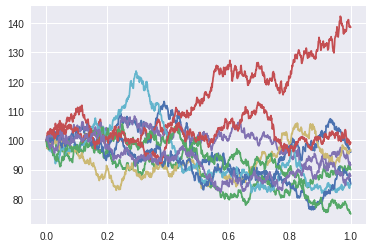

In [4]:
# Test the function SDE_path and generate 10 paths

for i in range(10): 
    [t, Y] = SDE_path(Mu, Sigma, 100., 0., 1., 1000); 
    plt.plot(t,Y);

In [0]:
# Define a function of call payoff by Euler method

def call_payoff(r, T, K, S_T):
    return np.exp(-r*T)*max(0,S_T - K)

In [17]:
# Calculate the price of call option by Euler method

T1 = 0; T2 = 1;
T = T2 - T1
K = 97
MeshL = 0.001
MeshN = int(T/MeshL)
IterN = 1000
call_price_list = np.zeros(IterN) #Simulation of payoff: to store the data of the payoff of each path or trajectory

for i in range(IterN):
    [t, Sh] = SDE_path(Mu, Sigma, s0, T1, T2, MeshN);
    call_price_list[i] = call_payoff(r, T, K, Sh[-1])
    
call_price = call_price_list.mean()
print(f"The price of the call option by the Euler method is {call_price}.")

The price of the call option by the Euler method is 11.127356825250878.



We can also create a class to generate the path of SDE using the Euler method

In [0]:
class SDE:
    def __init__(self, Mu, Sigma, InitState):
        self.Mu = Mu
        self.Sigma = Sigma
        self.InitState = InitState
        
    def Euler_method(self, T, N):
        x0 = self.InitState
        Mu = self.Mu
        Sigma = self.Sigma       
        t = np.linspace(0, T, N+1)
        
        Wh = np.zeros(N+1)   ##initial BM
        Sh =s0 + np.zeros(N+1)   ##initial Xh
        
        for i in range(N):  ##the Euler method
            DeltaT = t[i+1] - t[i]
            DeltaW = np.sqrt(t[i+1] - t[i]) * np.random.normal()
            Wh[i+1] = Wh[i] + DeltaW
            Sh[i+1] =Sh[i] + Mu(Sh[i], t[i]) * DeltaT + \
            Sigma(Sh[i], t[i])* DeltaW
            
        return t, Sh, Wh
        


In [0]:
# Define function drift and volatility

r = 0.03; sig = 0.2; gamma = 1;
Mu = lambda x,t: r*x
Sigma = lambda x,t: sig*x**gamma
s0 = 100. 

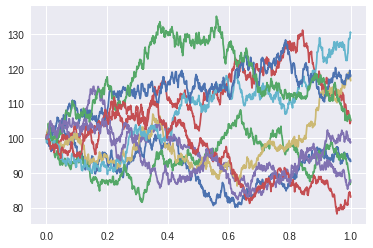

In [9]:
CEV1 = SDE(Mu, Sigma, s0)
for i in range(10): 
    [t, Y, W] = CEV1.Euler_method(1., 1000); 
    plt.plot(t,Y);

In [10]:
# Calculate the price of call option by Euler method
T1 = 0; T2 = 1;
T = T2 - T1
K = 97
MeshL = 0.001
MeshN = int(T/MeshL)
IterN = 1000
call_price_list = np.zeros(IterN) #Simulation of payoff: to store the data of the payoff of each path or trajectory

for i in range(IterN):
    [t, Sh] = SDE_path(Mu, Sigma, s0, T1, T2, MeshN);
    call_price_list[i] = call_payoff(r, T, K, Sh[-1])
    
call_price = call_price_list.mean()
print(f"The price of the call option by the Euler method is {call_price}.")

The price of the call option by the Euler method is 11.024106759791488.


(2) For $\sigma = 0.2$ and $\gamma = 1$, compute call price with $T = 1$ and $K = 97$. Dose it recover option price given by BSM formula?

From the question (1), we can get the estimator of call option price by Euler method. When $\gamma = 1$, the CEV model is:

$$d S_{t} = 0.03 S_{t} \, d t + 0.2 S_{t} \, d W_{t}, \, S_{0} = 100,$$

which becomes a BS model. So, we can recover option price given by BSM formula by Euler method when $\gamma = 1$. The call option price by the BSM as following:

In [0]:
def d1f(St, K, t, T, r, sigma):
    d1 = (np.log(St / K) + (r + 0.5 * sigma ** 2)
          * (T - t)) / (sigma * np.sqrt(T - t))
    return d1

In [0]:
def BSM_call_value(St, K, t, T, r, sigma):
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * np.sqrt(T - t)
    call_value = St * ss.norm.cdf(d1) - np.exp(-r * (T - t)) * K * ss.norm.cdf(d2)
    return call_value

In [13]:
# The parameters of this example

S0 = 100.0
K = 97
r = 0.03
sigma = 0.20
T = 1

print("The price of the call option under the BSM pricing model is ",  BSM_call_value(S0, K, 0, T, r, sigma))

The price of the call option under the BSM pricing model is  11.014613780922488


(3) Can you demostrate the weak or strong convergence rate?

When $\gamma = 1$, we can get the strong convergence rate as follows. Since the model is:

$$d S_{t} = 0.03 S_{t} \, d t + 0.2 S_{t} \, d W_{t}, \, S_{0} = 100,$$

we know that the explicit expression of $S_{t}$ is:

$$S_{t} = S_{0} \exp \{(r - \frac{1}{2} \sigma^{2}) t + \sigma W_{t} \},$$

where $r  = 0.03, \sigma = 0.2$ and $t = 1$.

Firstly, we need to build a function to get the explicit value of stock.

In [0]:
def explicit_value(s0, r, t, sigma, W_t):
        S_t= s0 * np.exp((r - sigma**2/2) * t + sigma * W_t)
        return S_t

In [0]:
CEV2 = SDE(Mu, Sigma, s0)
T = 1
NumSimu = 200
r = 0.03
size = 8
error_list = np.zeros(size)
T = 1.

for n in range(size):
    NumMesh = np.power(2, n + 4)
    error_sum = 0
    for i in range(NumSimu):
        [t, Sh, Wh] = CEV2.Euler_method(T, NumMesh)
        ShT = Sh[-1]
        ST = explicit_value(s0, r, T, sigma, Wh[-1])
        error_sum = error_sum + np.abs(ShT - ST)
    error_list[n] = error_sum/NumSimu

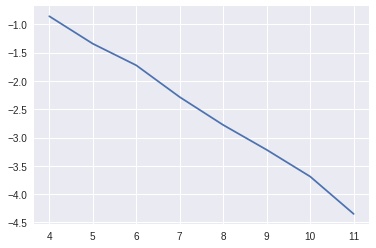

In [20]:
x_coordinate = np.arange(8) + 4
y_coordinate = np.log2(error_list)

plt.plot(x_coordinate, y_coordinate)

In [21]:
lg = ss.linregress(x_coordinate,y_coordinate)
rate = -lg[0]
print('The convergence rate is '+ str(rate))

The convergence rate is 0.4895942584736591


But for the weak convergence rate, we can not get it by the same method.

(4) Download option data and calibrate volatility and elasticity constant from 5 month call options.

In [23]:
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data = np.loadtxt('20optiondata2.dat', comments='#', delimiter=',')

print('>>>>>>otype, maturity, strike, option_price')
print(np_option_data)

>>>>>>otype, maturity, strike, option_price
[[  1.           0.16666667  97.           5.32705461]
 [  1.           0.16666667  99.           3.86224255]
 [  1.           0.16666667 101.           2.7204371 ]
 [  1.           0.16666667 103.           2.1202793 ]
 [  1.           0.41666667  97.           7.23756307]
 [  1.           0.41666667  99.           5.95053461]
 [  1.           0.41666667 101.           5.2640122 ]
 [  1.           0.41666667 103.           4.97493422]]
